In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('diabetes_prediction_dataset.csv')

print(df.shape)
df.head()

(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


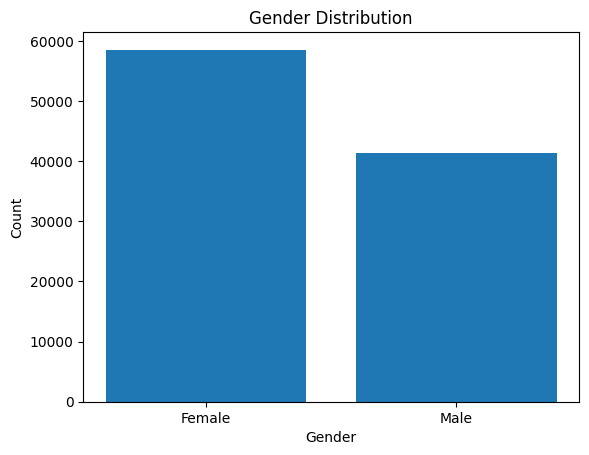

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'df'
# Replace 'df' with the actual name of your DataFrame

# Count the number of occurrences for each gender

df = df[df['gender'] != 'Other']
gender_counts = df['gender'].value_counts()

# Create a bar plot
plt.bar(gender_counts.index, gender_counts.values)


# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

# Display the plot
plt.show()

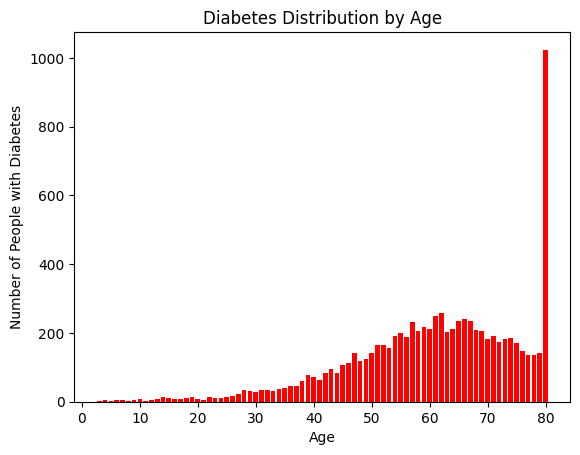

In [141]:
# Filter the DataFrame to include only people with diabetes
diabetes_df = df[df['diabetes'] == 1]

# Count the number of people with diabetes by age group
age_counts = diabetes_df['age'].value_counts().sort_index()

# Create a bar plot
plt.bar(age_counts.index, age_counts.values, color='red')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of People with Diabetes')
plt.title('Diabetes Distribution by Age')

# Display the plot
plt.show()

In [142]:
# Count the occurrences of "no_info" in the smoking_history column
no_info_count = df['smoking_history'].value_counts()['No Info']

print("Number of 'no_info' occurrences in smoking_history:", no_info_count)

Number of 'no_info' occurrences in smoking_history: 35810


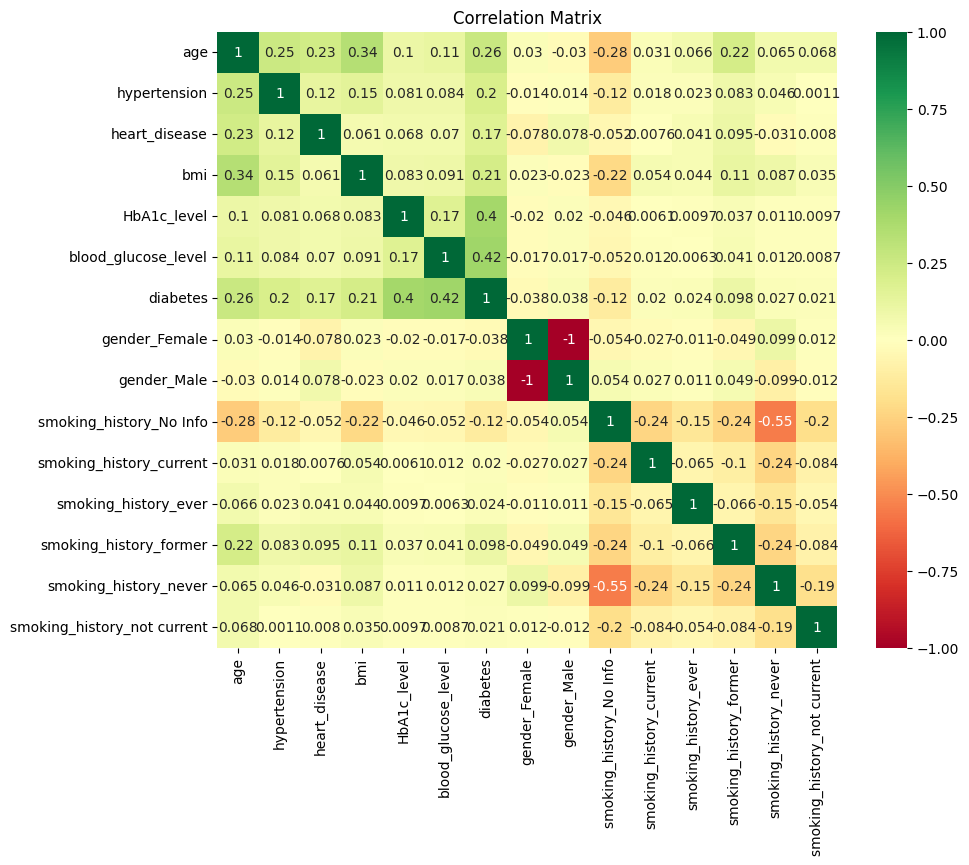

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select categorical columns to encode
categorical_columns = ['gender', 'smoking_history']

# Perform one-hot encoding on categorical columns
encoded_df = pd.get_dummies(df, columns=categorical_columns)

# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn")

# Add title
plt.title('Correlation Matrix')

# Display the plot
plt.show()


In [144]:
# Define a function to map the existing categories to new ones in order to reduce to 3 main categories of smoking
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df.loc[:, 'smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     70902
past_smoker    19794
current         9286
Name: count, dtype: int64


In [145]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

data = df.copy()

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

print(data.head())



    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  smoking_history_current  \
0         0           True        False                    False   
1         0           True        False                    False   
2         0          False         True                    False   
3         0           True        False                     True   
4         0          False         True                     True   

   smoking_history_non-smoker  smoking_history_past_smoker  
0                        True              

In [146]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Select the relevant attributes for the model
selected_attributes = ['gender', 'age', 'hypertension', 'heart_disease',
                       'smoking_history', 'bmi', 'HbA1c_level',
                       'blood_glucose_level', 'diabetes']

# Filter the DataFrame to include only the selected attributes
filtered_df = df[selected_attributes]

# Remove rows with missing values, if necessary
filtered_df.dropna(inplace=True)



# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])

# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()

# Split data into features and target variable
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Preprocess the data, oversample, and undersample
X_preprocessed = preprocessor.fit_transform(X)

X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)
# Split the data into training and testing sets



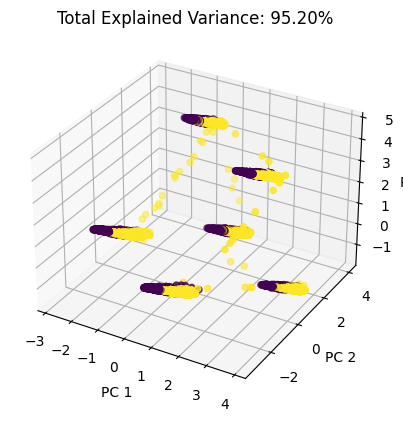

In [147]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler


X2 = X_resampled

scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

# Perform PCA on the feature data
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X2)

# Get the principal components
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]
pc3 = X_pca[:, 2]

# Create a scatter plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc1, pc2, pc3, c=y_resampled)

# Set the axis labels
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Set the title
total_var = sum(pca.explained_variance_ratio_) * 100
ax.set_title(f'Total Explained Variance: {total_var:.2f}%')

# Show the plot
plt.show()
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [148]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming your data is stored in a DataFrame called 'df'
# Replace 'df' with the actual name of your DataFrame

# Create the Keras model
model = Sequential()

model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

model.summary()

Epoch 1/10


2023-07-12 00:00:37.912206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4579/4579 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.7559

2023-07-12 00:01:09.881052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4579/4579 [==============================] - 35s 8ms/step - loss: 0.6183 - accuracy: 0.7559 - val_loss: 0.4804 - val_accuracy: 0.7799
Epoch 2/10
4579/4579 [==============================] - 34s 7ms/step - loss: 0.3369 - accuracy: 0.8556 - val_loss: 0.3560 - val_accuracy: 0.8412
Epoch 3/10
4579/4579 [==============================] - 34s 7ms/step - loss: 0.2902 - accuracy: 0.8731 - val_loss: 0.1811 - val_accuracy: 0.9377
Epoch 4/10
4579/4579 [==============================] - 31s 7ms/step - loss: 0.2753 - accuracy: 0.8750 - val_loss: 0.2142 - val_accuracy: 0.9122
Epoch 5/10
4579/4579 [==============================] - 33s 7ms/step - loss: 0.2744 - accuracy: 0.8750 - val_loss: 0.2696 - val_accuracy: 0.8776
Epoch 6/10
4579/4579 [==============================] - 34s 7ms/step - loss: 0.2706 - accuracy: 0.8757 - val_loss: 0.2700 - val_accuracy: 0.8770
Epoch 7/10
4579/4579 [==============================] - 33s 7ms/step - loss: 0.2721 - accuracy: 0.8756 - val_loss: 0.1513 - val_accuracy: 0.9

1139/1139 [==============================] - 5s 5ms/step - loss: 0.2836 - accuracy: 0.8751
Test Loss: 0.2836281955242157
Test Accuracy: 0.8750686049461365
  96/1139 [=>............................] - ETA: 1s

2023-07-12 00:06:18.420989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1139/1139 [==============================] - 2s 2ms/step


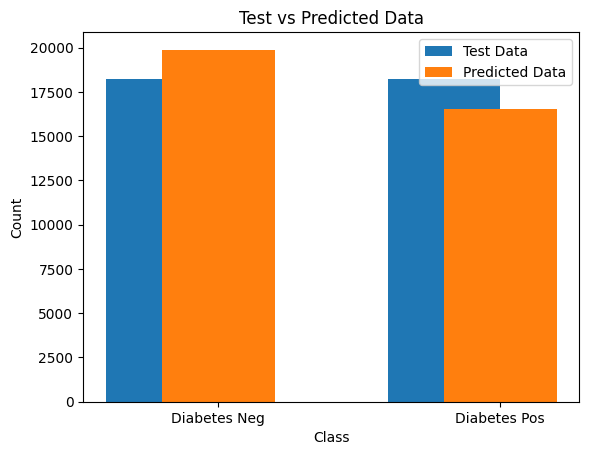

In [149]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)

# Print the test loss and accuracy
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already trained the model and obtained the predictions

# Convert the predictions to binary values (0 or 1)
predicted_classes = np.round(model.predict(X_test_resampled)).flatten()

# Count the number of occurrences for each class in the test data
test_counts = np.bincount(y_test_resampled.astype(int))

# Count the number of occurrences for each class in the predicted data
predicted_counts = np.bincount(predicted_classes.astype(int))

# Calculate the x-axis positions for the bars
x_test = np.arange(len(test_counts))
x_predicted = x_test + 0.2  # Adjust the position of the predicted bars slightly

# Create a bar plot for the test data
plt.bar(x_test, test_counts, width=0.4, label='Test Data')

# Create a bar plot for the predicted data
plt.bar(x_predicted, predicted_counts, width=0.4, label='Predicted Data')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test vs Predicted Data')
plt.legend()

# Adjust the x-axis ticks and labels
plt.xticks(x_test + 0.2, ['Diabetes Neg', 'Diabetes Pos'])

# Display the plot
plt.show()





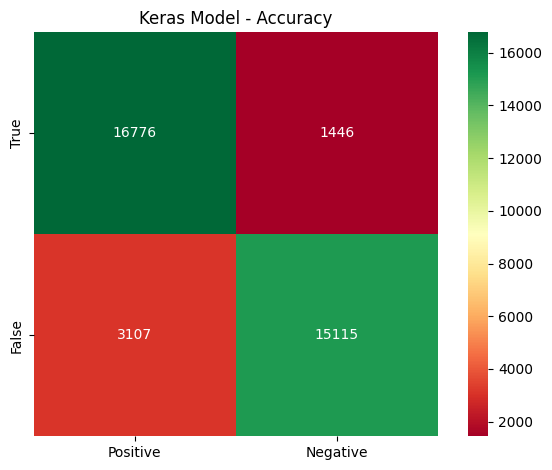

In [151]:
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
cm = confusion_matrix(y_test_resampled, predicted_classes)

# Plot the confusion matrix as an image
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar

# Add labels, title, and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Keras Model - Accuracy')
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', xticklabels=['Positive', 'Negative'], yticklabels=['True', 'False'])


# Display the plot
plt.tight_layout()
plt.show()